# Prerequisite
-----------------------------
- Install Nanum fonts if you'll use matplot displaying in showAttention function.
- After installing, then restart runtime.
- All the training data is up to you. you need to gather any data separately.


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,738 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 144865 files and d

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from gensim.models import FastText
fastTrain = []
def getFast():
  f = open('/content/drive/My Drive/AI_KAIST_embedding2.txt','r')
  lines = f.readlines()

  count = 0

  for line in lines:
    line = line.split()
    for item in line:
      if item == '':
        line.remove(item)
    fastTrain.append(line)
    # if count == 2:
    #     break
    # else:
    #     count += 1

getFast()
fastTrain.append(['SOS', 'EOS'])
print(len(fastTrain))
print(fastTrain[:3])
# print(fastTrain)


203559
[['늘:VV', '어요:SEF'], ['present', 'polite', 'informal', '어요:SEF'], ['늘:VV', '었:EP', '잖아:SEF']]


In [4]:
# Training for word embedding
fastModel = FastText(size=256, window=3, min_count=1, sg=1)  # instantiate
fastModel.build_vocab(sentences=fastTrain)
fastModel.train(sentences=fastTrain, total_examples=len(fastTrain), epochs=10)  # train

In [5]:
import operator
words= []
word2index = {}
idx = 0
for word in fastModel.wv.vocab.keys():
  words.append(word)
  word2index[word] = idx
  idx += 1
print(words)
print(word2index)
print(word2index['SOS'])
print(word2index['EOS'])
sos_index = word2index['SOS']
eos_index = word2index['EOS']
sos_swap_word = words[0]
eos_swap_word = words[1]
 
words[0], words[sos_index] = words[sos_index], words[0]
words[1], words[eos_index] = words[eos_index], words[1]
word2index[sos_swap_word], word2index['SOS'] = word2index['SOS'], word2index[sos_swap_word]
word2index[eos_swap_word], word2index['EOS'] = word2index['EOS'], word2index[eos_swap_word]
word2index = { k : v for k , v in sorted(word2index.items(), key=operator.itemgetter(1))}


print(words)
print(len(words))
print(word2index)

['늘:VV', '어요:SEF', 'present', 'polite', 'informal', '었:EP', '잖아:SEF', 'past', 'as', 'you', 'know', 'ㄹ_것이:TNS', '에요:SEF', 'future', '고_있:TNS', '다:SEF', 'progressive', 'plain-style', '네요:SEF', 'showing', 'surprise', '구나:SEF', 'exclamation', '습니다:SEF', 'formal', 'statement', '고있:TNS', 'ㄴ다:SEF', '겠:TNS', 'will', 'ㅂ니다:SEF', '어떻:VA', '니:SEF', 'question', '습니까:SEF', 'probably', 'ㄴ가:SEF', 'ㄴ데요:SEF', '/', 'opinion', '나요:SEF', 'soft', 'ㄴ가요:SEF', 'ㄹ까:SEF', 'tentative', 'ㄹ까요:SEF', '을까:SEF', '냐:SEF', '지:SEF', "isn't", 'it?', '을까요:SEF', '늘리:VV', 'ㄹ것이:TNS', '시어요:SEF', 'please', 'do', '자:SEF', 'proposal', '는가:SEF', 'familiar-style', '보:VX', '았:EP', '군요:SEF', 'ㄹ게:SEF', '아요:SEF', 'ㄹ게요:SEF', '시ㅂ시오:SEF', '아라:SEF', 'commands', 'ㄹ래:SEF', 'willing', 'to', 'ㅂ시다:SEF', '네:SEF', '야:SEF', 'intimate', 'style', '준비되:VHV', '어_있:AUX', '걸리:VV', 'ㄹ_것_같:VMOD', '은데요:SEF', '은가:SEF', '받:VV', '고_싶:AUX', '을_것이:TNS', '으시어요:SEF', '은가요:SEF', '가능하:VHA', '여_보이:AUX', '는데요:SEF', '이:VCP', '잖아요:SEF', '오:SEF', 'semi-formal', '지요:SEF',

# Data loading

### train data
[input sequence -> output sequence]

풀리:VV ㄹ_것이:TNS 다:SEF progressive plain-style -> 풀리:VV 고_있:TNS 다:SEF 

늘:VV 었:EP 잖아:SEF future plain-style -> 늘:VV ㄹ_것이:TNS 다:SEF

어떻:VA 었:EP 을까:SEF probably formal question -> 어떻:VA 겠:TNS 습니까:SEF


In [6]:
# vocab dictionary

SOS = 0
EOS = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = { k : v for k , v in sorted(word2index.items(), key=operator.itemgetter(1))}
    self.word2count = { word : 1 for word in words }
    self.index2word = { i : word for word, i in word2index.items() }
    self.n_words =  7271
  
  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)
  
  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1
      

In [7]:
# read file
morPairs = []
def readLangs():
    print("Reading lines...")
    # 파일을 읽고 줄로 분리
    lines = open('/content/drive/My Drive/AI_KAIST_training.txt', encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[ s for s in l.split(' -> ')] for l in lines]
    # templen = int(len(pairs)*0.9)
    # print(templen)
    # print(len(pairs)*0.9)
    # print(len(pairs))
    # pairs = pairs[:templen]
    random.shuffle(pairs)
    print("total pairs:", len(pairs))
    return pairs


In [8]:
MAX_LENGTH = 20
morPairs = readLangs()
max = 0
def prepareData():
  pairLength = len(morPairs)
  pairs = morPairs[:int(pairLength*0.9)]
  print("pairs to train:", len(pairs))
  # pairs = pairs[:int(pairLength*0.9)]
  lang = Lang("")
  #print("Read %s sentence pairs" % len(pairs))
  #print("Counting words...")
  #for pair in pairs:
    #   lang.addSentence(pair[0])
  #print("Counted words:")
  #print(lang.name, lang.n_words)
  return lang, pairs
  #return pairs

lang, pairs = prepareData()
#pairs = prepareData()
print(pairs[:10])
for pair in pairs:
  a = pair[0].split()
  if len(a) > max:
    max = len(a)
print(max)

Reading lines...
total pairs: 1050226
pairs to train: 945203
[['기ㄴ_하:VNOM 냐:SEF past showing surprise', '기ㄴ_하:VNOM 였:EP 네요:SEF'], ['풀리:VV ㄹ_것이:TNS 다:SEF progressive plain-style', '풀리:VV 고_있:TNS 다:SEF'], ['찾아보:VV ㄹ래요:SEF present plain-style proposal', '찾아보:VV 자:SEF'], ['주:VV 겠:TNS 니:SEF progressive familiar-style question', '주:VV 고_계시:TNS 는가요:SEF'], ['되:VV 지_않:NEG 고_있:TNS 어요:SEF future polite informal', '되:VV 지_않:NEG 을_것이:TNS 에요:SEF'], ['이:VCP 었:EP 다:SEF present polite question', '이:VCP ㄴ가요:SEF'], ['잡히:VV 었:EP 다:SEF present soft question', '잡히:VV 나요:SEF'], ['방문하:VHV 여주:AUX 시ㅂ시오:SEF present polite informal', '방문하:VHV 여주:AUX 어요:SEF'], ['참:VV 았:EP 다:SEF present plain-style proposal', '참:VV 자:SEF'], ['참여하:VHV 겠:TNS 습니다:SEF progressive familiar-style question', '참여하:VHV 고_있:TNS 는가:SEF']]
17


In [9]:
# Measure each word's weight matrix for attaching to embedding layer.
matrix_len = lang.n_words
 
weights_matrix = np.zeros((matrix_len, 256))
words_found = 0
 
for i, word in enumerate(lang.word2index):
    try: 
        weights_matrix[i] = fastModel.wv[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(4, ))
print(weights_matrix)

[[ 0.01339282  0.00356468 -0.01472328 ...  0.00110091  0.01525677
   0.01410951]
 [-0.04246243  0.09438078  0.02279524 ... -0.00613446  0.05505755
   0.01773589]
 [ 0.46833873 -0.30991516 -0.28431594 ...  0.14352307  0.247283
  -0.23201907]
 ...
 [ 0.34432709 -0.05148871 -0.34152988 ...  0.29656535  0.07969167
   0.09766031]
 [ 0.49159327  0.07403623 -0.49105632 ...  0.34895799  0.31258276
   0.18168196]
 [ 0.2009346   0.09227394 -0.03400306 ...  0.28352779  0.02614563
   0.41546991]]


# Seq2Seq model




In [10]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()    
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1)
    output = embedded
    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)


In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
def indexesFromSentence(lang, sentence):
  wordList = sentence.strip().split(' ')  
  try:
    for word in wordList:
        if word == '':
          wordList.remove(word)
  except:
    print(wordList)
  return [lang.word2index[word] for word in wordList]
   


def tensorFromSentence(sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(pair[0])
    target_tensor = tensorFromSentence(pair[1])
    return (input_tensor, target_tensor)

In [13]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):

            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            if di == 0:
                decoder_input = target_tensor[di]
            else:
                decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
%matplotlib inline
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.switch_backend('agg')
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

0m 8s (- 74m 14s) (100 0%) 6.4204
0m 17s (- 73m 0s) (200 0%) 5.5110
0m 26s (- 73m 35s) (300 0%) 4.8882
0m 34s (- 71m 59s) (400 0%) 4.5330
0m 43s (- 71m 47s) (500 1%) 4.7444
0m 52s (- 72m 17s) (600 1%) 4.5593
1m 1s (- 72m 31s) (700 1%) 4.4572
1m 10s (- 72m 13s) (800 1%) 4.4576
1m 19s (- 72m 16s) (900 1%) 4.3715
1m 28s (- 72m 13s) (1000 2%) 4.3502
1m 37s (- 71m 54s) (1100 2%) 4.3712
1m 46s (- 71m 53s) (1200 2%) 4.2844
1m 54s (- 71m 43s) (1300 2%) 4.4344
2m 3s (- 71m 28s) (1400 2%) 4.1622
2m 12s (- 71m 10s) (1500 3%) 4.2923
2m 21s (- 71m 11s) (1600 3%) 4.0977
2m 30s (- 71m 5s) (1700 3%) 4.0773
2m 38s (- 70m 53s) (1800 3%) 4.1722
2m 48s (- 70m 57s) (1900 3%) 4.0563
2m 57s (- 70m 54s) (2000 4%) 4.1325
3m 6s (- 70m 43s) (2100 4%) 4.0826
3m 15s (- 70m 36s) (2200 4%) 4.0690
3m 23s (- 70m 28s) (2300 4%) 4.0506
3m 32s (- 70m 20s) (2400 4%) 4.0935
3m 41s (- 70m 11s) (2500 5%) 4.0472
3m 50s (- 70m 10s) (2600 5%) 3.9138
3m 59s (- 70m 1s) (2700 5%) 3.8430
4m 8s (- 69m 48s) (2800 5%) 3.9090
4m 17s (-

<Figure size 432x288 with 0 Axes>

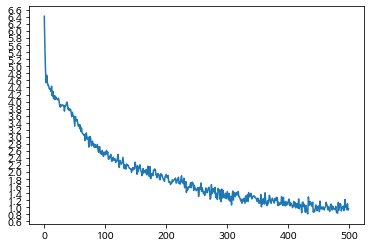

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 50000, print_every=100)

In [18]:
%matplotlib inline
def OOVChecker(sentence):
  flag = False
  sentence = sentence.split()
  for word in sentence:
    if word == '':
      sentence.remove(word)
  for i in range(0, len(sentence)):
    if sentence[i] not in fastModel.wv.vocab:
      oovVec = fastModel.wv[sentence[i]]
      (sentence[i], prob) = fastModel.wv.most_similar(positive=[sentence[i]])[0]
      flag = True
      break
  return ' '.join(sentence), flag

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        originalVerb = sentence.split()[0]
        sentence, flag = OOVChecker(sentence)
        input_tensor = tensorFromSentence(sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            
            if topi.item() == EOS:
                decoded_words.append('<EOS>')
                break
            elif di == 0:
                decoded_words.append(lang.index2word[input_tensor[0].item()])
            else:
                decoded_words.append(lang.index2word[topi.item()])

            
            decoder_input = topi.squeeze().detach()
        if flag:
          decoded_words[0] = originalVerb

        return decoded_words, decoder_attentions[:di + 1]

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    a = [''] + ['<SOS>'] + input_sentence.split(' ') + ['<EOS>']
    ax.set_xticklabels(a, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  

    plt.show();

def evaluateRandomly(encoder, decoder, n=10):
    pairsLength = len(morPairs);
    pairsToEvaluate = morPairs[int(pairsLength*0.9):]
    print("length to evaluaut:", len(pairsToEvaluate))
    for i in range(n):
        pair = random.choice(pairsToEvaluate)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        showAttention(pair[0], output_words, attentions)
        #display_attention(pair[0], output_words, attentions)
        print('')



# Result



length to evaluaut: 105023
> 잡:VV 아주:AUX ㄹ게:SEF present willing to
= 잡:VV 아주:AUX ㄹ래요:SEF
< 잡:VV 아주:AUX ㄹ래요:SEF <EOS>


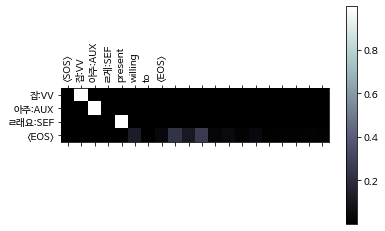


> 사:VV 도록_하:AUX 였:EP 다:SEF present plain-style proposal
= 사:VV 도록_하:AUX 자:SEF
< 사:VV 도록_하:AUX 자:SEF <EOS>


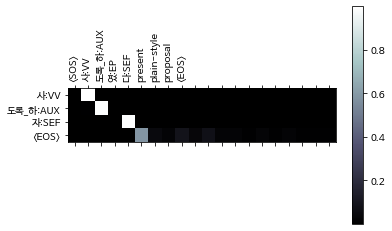


> 변경하:VHV ㄹ_것이:TNS ㅂ니다:SEF progressive plain-style
= 변경하:VHV 고_있:TNS 다:SEF
< 변경하:VHV 고_있:TNS 다:SEF <EOS>


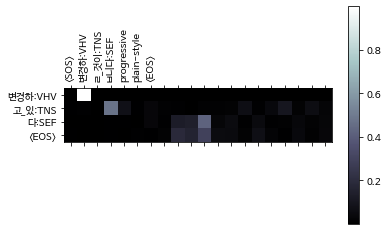


> 받:VV 도록_하:AUX 였:EP 다:SEF present formal proposal
= 받:VV 도록_하:AUX ㅂ시다:SEF
< 받:VV 도록_하:AUX ㅂ시다:SEF <EOS>


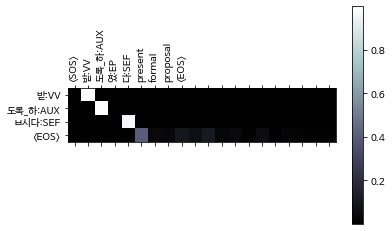


> 만나:VV 지_않:NEG 고_있:TNS 어요:SEF present polite informal
= 만나:VV 지_않:NEG 아요:SEF
< 만나:VV 지_않:NEG 아요:SEF <EOS>


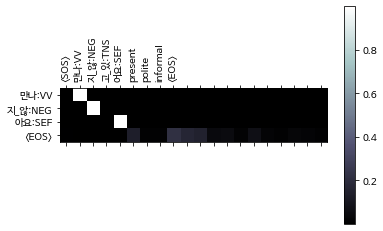


> 가져가:VV ㄹ까:SEF past showing surprise
= 가져가:VV 았:EP 네:SEF
< 가져가:VV 였:EP 네요:SEF <EOS>


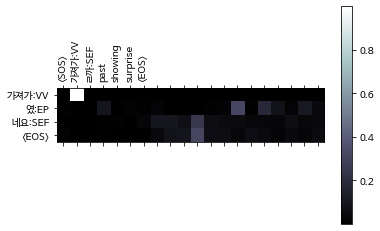


> 돌려주:VV ㄹ_것이:TNS 에요:SEF past formal statement
= 돌려주:VV 었:EP 습니다:SEF
< 돌려주:VV 었:EP 습니다:SEF <EOS>


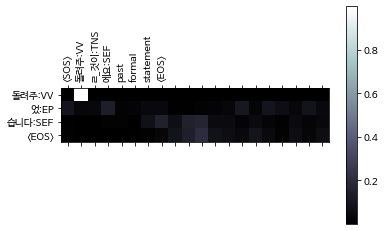


> 있:VV 을것이:TNS ㅂ니다:SEF present plain-style commands
= 있:VV 거라:SEF
< 있:VV 어라:SEF <EOS>


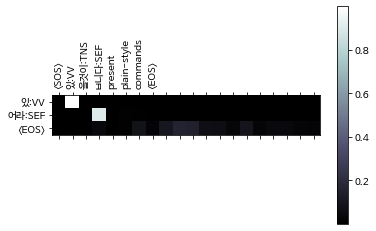


> 쓰:VV 었:EP 거든요:SEF present plain-style proposal
= 쓰:VV 자:SEF
< 쓰:VV 자:SEF <EOS>


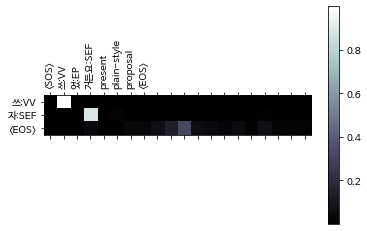


> 아니:VCN 었:EP 군요:SEF past showing surprise
= 아니:VCN 었:EP 네요:SEF
< 아니:VCN 었:EP 네요:SEF <EOS>


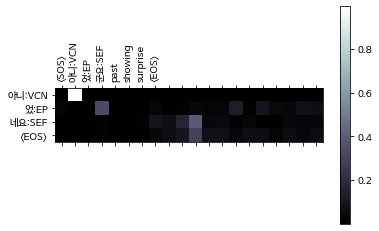

In [19]:
evaluateRandomly(encoder1, attn_decoder1)

In [ ]:
# Evaluate directly
evaluate(encoder1, attn_decoder1, '구인하:VHV 였:EP 을_것이:TNS ㅂ니다:SEF present soft question')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


(['구인하:VHV', '나요:SEF', '<EOS>'],
 tensor([[1.4680e-06, 7.2326e-06, 9.9997e-01, 1.8763e-06, 7.0885e-07, 2.3697e-07,
          3.3746e-07, 4.8683e-06, 1.1076e-06, 1.0423e-06, 1.8956e-06, 9.5318e-07,
          6.6331e-07, 1.5930e-06, 5.2465e-07, 1.3592e-06, 2.7621e-06, 6.8805e-07,
          9.7816e-07, 1.9498e-06],
         [1.3748e-03, 2.1146e-04, 4.2730e-03, 3.8330e-02, 2.2095e-03, 1.8225e-01,
          4.3963e-02, 6.3946e-01, 1.0983e-02, 4.7308e-03, 1.5987e-02, 9.1310e-03,
          3.5939e-03, 3.1195e-03, 2.6024e-03, 6.9463e-03, 9.6037e-03, 4.4122e-03,
          7.6731e-03, 9.1511e-03],
         [1.2648e-03, 1.6310e-04, 9.9049e-08, 4.1833e-04, 7.2322e-04, 9.3376e-04,
          2.4935e-02, 7.3431e-01, 1.4253e-02, 6.4067e-02, 2.9983e-02, 9.3471e-03,
          1.5078e-02, 4.5933e-03, 8.9861e-03, 1.2406e-02, 3.5584e-03, 2.9037e-02,
          1.3623e-02, 3.2322e-02]]))

In [ ]:
# Save sequence to sequence model
torch.save(encoder1.state_dict(), '/content/drive/My Drive/model/encoder.dict')
torch.save(attn_decoder1.state_dict(), '/content/drive/My Drive/model/decoder.dict')

In [ ]:
# Save model of FastText
fastModel.save('/content/drive/My Drive/model/FastText.model')

In [25]:
# Test cell for checking OOV
if '서사하:VHV' in word2index:
  print(True)
else:
  print(False)
  print(fastModel.wv.most_similar('서사하:VHV'))

False
[('묘사하:VHV', 0.9070539474487305), ('조사하:VHV', 0.9049344658851624), ('봉사하:VHV', 0.9036099910736084), ('약속하:VHV', 0.9033485651016235), ('이사하:VHV', 0.9026130437850952), ('인사하:VHV', 0.90250563621521), ('선사하:VHV', 0.9024760723114014), ('퇴사하:VHV', 0.901898205280304), ('시사하:VHV', 0.9017912149429321), ('입사하:VHV', 0.9017260670661926)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
